# Image Registration Pedagogy
### Week of 3.1.2018

In [1]:
# python 2/3 compatibility
from __future__ import print_function

# numerical python
import numpy as np

# file management tools
import glob
import os

# good module for timing tests
import time

# plotting stuff
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# ability to read/write fits files
from astropy.io import fits

# fancy image combination technique
from astropy.stats import sigma_clipping

# median absolute deviation: for photometry
from astropy.stats import mad_std

# photometric utilities
from photutils import DAOStarFinder,aperture_photometry, CircularAperture, CircularAnnulus



### Step 0: Import A341 Definitions

And read their documentation!

In [2]:
# make the definitions for reading in images accessible in this notebook.
from HDI_io import *

In [3]:
# load up shifting methods
from shift_methods import *

In [4]:
# test these out individually!

centroid?
shift_image?
cross_image?


## Step 1: Read in some data

In [5]:
data_arr1 = fits.getdata('/Volumes/A341/20180118/StdUR_20180118_I_0.fits')
data_arr0 = fits.getdata('/Volumes/A341/20180118/StdUR_20180118_V_0.fits')

## Step 2: Identify Stars in Image

Using data_arr0. The same center is applied to data_arr1, assuming that the offsets are small (<5 pixels). For larger offsets, the matching star may need to be manually found.

In [6]:

nsigma=100. # detection threshold in sigma: select brighter stars
FWHM=4. # pixels


bkg_sigma = mad_std(data_arr0)
daofind = DAOStarFinder(fwhm=8., threshold=nsigma*bkg_sigma)

sources = daofind(data_arr0)

xpos = np.array(sources['xcentroid'])
ypos = np.array(sources['ycentroid'])



print('detected {} sources'.format(len(sources['xcentroid'])))

detected 132 sources


In [7]:
# select a star position close to the center


xhalf = data_arr0.shape[0]/2.
yhalf = data_arr0.shape[1]/2.

# the actual star closest to the image center
closest_r = np.argmin(((xpos-xhalf)**2. + (ypos-yhalf)**2.)**0.5)

print('Selected star is at x={} and y={}'.format(np.round(xpos[closest_r],2),np.round(ypos[closest_r],2)))

xcen = xpos[closest_r]
ycen = ypos[closest_r]



Selected star is at x=2180.63 and y=1774.37


## Step 2: Calculate a center and plot

1. Image 1

Fitted centroid star is at x=2181.47 and y=1775.07
Corresponding to shifts of dx=0.84 and dy=0.7


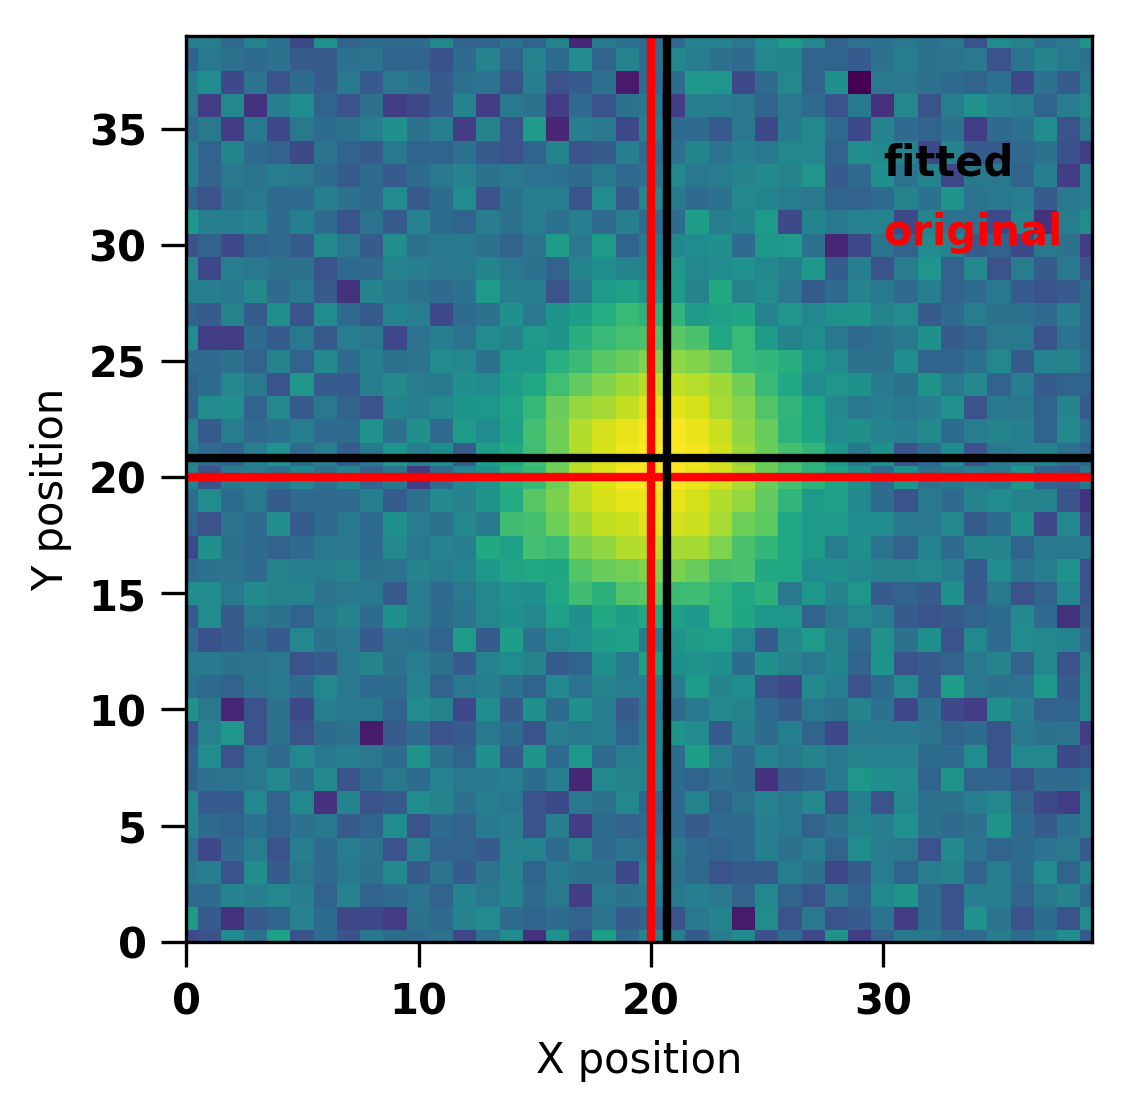

In [8]:



plt.imshow(np.arcsinh(np.arcsinh(data_arr0.T[int(xcen-20):int(xcen+20),int(ycen-20):int(ycen+20)])),origin='lower',cmap=cm.viridis)

xcens0,ycens0 = centroid(data_arr0,xcen,ycen,nhalf=6,derivshift=1.)

xshift0 = (xcens0-xcen)
yshift0 = (ycens0-ycen)

plt.plot([20,20],[0,40],color='red')
plt.plot([0,40],[20,20],color='red')

plt.plot([20+yshift0,20+yshift0],[0,40],color='black')
plt.plot([0,40],[20+xshift0,20+xshift0],color='black')

plt.text(30,30,'original',color='red')
plt.text(30,33,'fitted',color='black')

plt.xlabel('X position')
plt.ylabel('Y position')

plt.axis([0.,39,0,39])

print('Fitted centroid star is at x={} and y={}'.format(np.round(xcens0,2),np.round(ycens0,2)))
print('Corresponding to shifts of dx={} and dy={}'.format(np.round(xshift0,2),np.round(yshift0,2)))





2. Image 2

The shift must be small, or this will fail.

Fitted centroid star is at x=2182.55 and y=1774.33
Corresponding to shifts of dx=1.92 and dy=-0.04


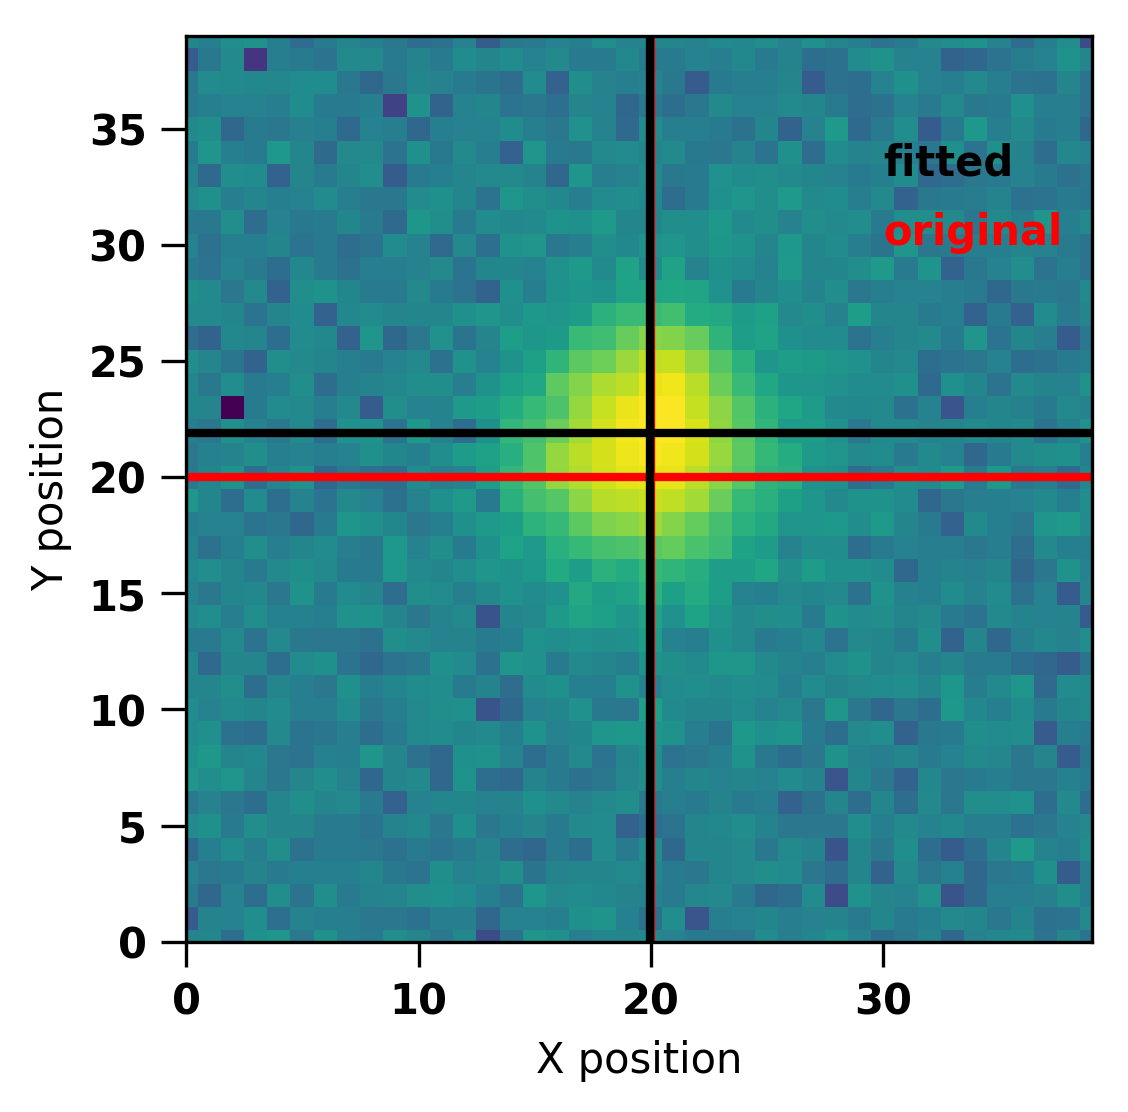

In [9]:



plt.imshow(np.arcsinh(np.arcsinh(data_arr1.T[int(xcen-20):int(xcen+20),int(ycen-20):int(ycen+20)])),origin='lower',cmap=cm.viridis)

xcens1,ycens1 = centroid(data_arr1,xcen,ycen,nhalf=6,derivshift=1.)

xshift1 = (xcens1-xcen)
yshift1 = (ycens1-ycen)

plt.plot([20,20],[0,40],color='red')
plt.plot([0,40],[20,20],color='red')

plt.plot([20+yshift1,20+yshift1],[0,40],color='black')
plt.plot([0,40],[20+xshift1,20+xshift1],color='black')

plt.text(30,30,'original',color='red')
plt.text(30,33,'fitted',color='black')

plt.xlabel('X position')
plt.ylabel('Y position')

plt.axis([0.,39,0,39])

print('Fitted centroid star is at x={} and y={}'.format(np.round(xcens1,2),np.round(ycens1,2)))
print('Corresponding to shifts of dx={} and dy={}'.format(np.round(xshift1,2),np.round(yshift1,2)))





3. Check the shifts empirically from the centroiding on a star.

In [ ]:
print('Image-to-image shifts of dx={} and dy={}'.format(np.round(xshift1-xshift0,2),np.round(yshift1-yshift0,2)))

print('(therefore, apply these backwards to data_arr1 to align with data_arr2)')

Image-to-image shifts of dx=1.08 and dy=-0.73
(therefore, apply these backwards to data_arr1 to align with data_arr2)


## Step 3: Do A Cross-Correlation Shift Calculation

For the data, compute the cross-correlation to get a more accurate shift.

In [ ]:
# test multiple boxsizes for stability (and timing!)
t0 = time.time()

xshift,yshift = cross_image(data_arr0,data_arr1,boxsize=1000)
t1 = time.time()
print('boxsize=1000: dx={}, dy={}, in dt={}s'.format(np.round(xshift,2),np.round(yshift,2),np.round(t1-t0,2)))

xshift,yshift = cross_image(data_arr0,data_arr1,boxsize=2000)
t2 = time.time()
print('boxsize=2000: dx={}, dy={}, in dt={}s'.format(np.round(xshift,2),np.round(yshift,2),np.round(t2-t1,2)))

xshift,yshift = cross_image(data_arr0,data_arr1,boxsize=3000)
t3 = time.time()
print('boxsize=3000: dx={}, dy={}, in dt={}s'.format(np.round(xshift,2),np.round(yshift,2),np.round(t3-t2,2)))

xshift,yshift = cross_image(data_arr0,data_arr1)
t4 = time.time()
print('boxsize=full: dx={}, dy={}, in dt={}s'.format(np.round(xshift,2),np.round(yshift,2),np.round(t4-t2,2)))



boxsize=1000: dx=0.99, dy=-0.08, in dt=0.81s


## Step 4:  Check Results

Test the shifts by re-calculating the centroid of the initial star.

In [ ]:

# the original 0 image star
print('            Fitted centroid star is at x={} and y={}'.format(np.round(xcens0,2),np.round(ycens0,2)))

new_img = shift_image(data_arr1,xshift,yshift)
xcen_new,ycen_new = centroid(new_img,xcen,ycen,nhalf=10,derivshift=1.)

print('           Shifted centroid star is at x={} and y={}'.format(np.round(xcen_new,2),np.round(ycen_new,2)))

print('(these should agree--difference is absolute accuracy of shifting method)')
      
print('--compare to--')

print('        UN-Shifted centroid star is at x={} and y={}'.format(np.round(xcens1,2),np.round(ycens1,2)))




# this checks how robust the centroid is by moving the centroid
xcen_new = xcen+xshift
ycen_new = ycen+yshift

xcen_shift,ycen_shift = centroid(data_arr1,xcen_new,ycen_new,nhalf=10,derivshift=1.)

print('Recomputed shifted centroid star is at x={} and y={}'.format(np.round(xcen_shift,2),np.round(ycen_shift,2)))

print('(these should agree, the disagreement says something about the centroiding tolerance)')



